<a href="https://colab.research.google.com/github/ruthelphor/Projet_court_AIAO_M2BI/blob/main/Projet_mnist_deep_learning_yamadjako.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet court : Classification d’images bruitées de chiffres**


## **1. Charger les images avec numpy.load()**


First, import some modules necessary for data analysis and transformation:

In [48]:
import pandas as pd
import numpy as np
#import sklearn
import matplotlib.pyplot as plt
import os
import requests
from tqdm.auto import tqdm

Read the data to variables (it will take some time for x since we have a lot of data):

In [ ]:
train_images = np.load("/content/train_images.npy")
train_labels = np.load("/content/train_labels.npy")
test_images = np.load("/content/test_images.npy")
test_labels = np.load("/content/test_labels.npy")

## **2. Visualiser quelques images:**

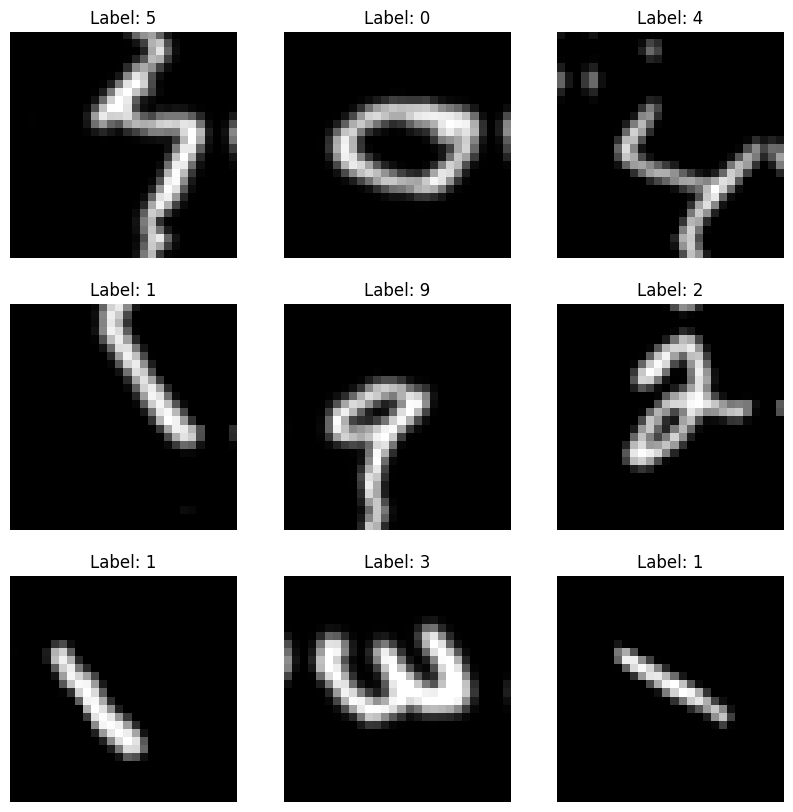

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

How many examples do we have in our dataset?

In [ ]:
print(f'Shape of data X_train:{train_images.shape}\n')
print(f'Shape of data Y_train:{train_labels.shape}\n')
print(f'Shape of data X_test:{test_images.shape}\n')
print(f'Shape of data Y_test:{test_labels.shape}\n')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data Y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data Y_test:(10000,)



## **3. Premier apprentissage et validation de la classification : Fully Connected Neural Network**

**Modèle de base avec deux couches entièrement connectées :**

* Fonction d'activation des neurones : Rectified Linear Unit (ReLU).

* Fonction d'activation de sortie : Softmax (pour la classification multi-classes).

* Fonction de coût : Cross-entropy (entropie croisée).

* Deux couches cachées avec respectivement 256 et 128 neurones.

* Dropout : 30 % (technique pour éviter le surapprentissage).

* Optimiseur : RMSprop.

### Préparation

Importation des modules nécessaires pour la construction de modèles d'apprentissage profond.

In [ ]:
!pip install scikeras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

from keras.layers import Conv1D, Flatten
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import optimizers

# Useful Sklearn library
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.metrics

from keras.utils import to_categorical
from keras.utils import plot_model

One hot encoding of class labels

In [ ]:
y_train_oh = to_categorical(train_labels)
y_test_oh = to_categorical(test_labels)
print(f'One hot encoding of y_train : {y_train_oh}\n')
print(f'Shape of y_train_oh : {y_train_oh.shape}')


print(f'One hot encoding of y_test : {y_test_oh}\n')
print(f'Shape of y_test_oh : {y_test_oh.shape}')

One hot encoding of y_train : [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

Shape of y_train_oh : (60000, 10)
One hot encoding of y_test : [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Shape of y_test_oh : (10000, 10)


Afficher la forme des données avant la division:

In [ ]:
print(f'X_train shape : {train_images.shape}')
print(f'Y_train one-hot shape : {y_train_oh.shape}')
print(f'X_test shape : {test_images.shape}')
print(f'Y_test one-hot shape : {y_test_oh.shape}')

X_train shape : (60000, 28, 28, 1)
Y_train one-hot shape : (60000, 10)
X_test shape : (10000, 28, 28, 1)
Y_test one-hot shape : (10000, 10)


Division des données d'entraînement pour avoir un ensemble de validation

In [ ]:
X_train_final, X_val, y_train_final, y_val = train_test_split(train_images, y_train_oh, test_size=0.2, random_state=3, shuffle=True)


Afficher les formes des ensembles après la division:

In [ ]:
print(f'X_train_final shape : {X_train_final.shape}')
print(f'X_val shape : {X_val.shape}')
print(f'y_train_final shape : {y_train_final.shape}')
print(f'y_val shape : {y_val.shape}')

print(y_train_final[0])
print(y_val[0])

X_train_final shape : (48000, 28, 28, 1)
X_val shape : (12000, 28, 28, 1)
y_train_final shape : (48000, 10)
y_val shape : (12000, 10)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Définition du modèle

In [ ]:
def dense_model_mnist():
    # Créer le modèle séquentiel
    model = Sequential()

    # Première couche dense avec 256 neurones et ReLU
    model.add(Dense(256, input_shape=(28*28,), activation='relu'))

    # Dropout de 30% pour régularisation
    model.add(Dropout(0.3))

    # Deuxième couche dense avec 128 neurones et ReLU
    model.add(Dense(128, activation='relu'))

    # Dropout de 30% pour régularisation
    model.add(Dropout(0.3))

    # Couche de sortie avec 10 neurones (10 classes pour les chiffres 0 à 9) avec softmax
    model.add(Dense(10, activation='softmax'))

    # Utilisation de l'optimiseur RMSprop
    opt = RMSprop()

    # Compilation du modèle avec categorical crossentropy et métrique de précision
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model


Résumé et structure du modele

In [ ]:
model = dense_model_mnist()
print(f'{model.summary()}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None


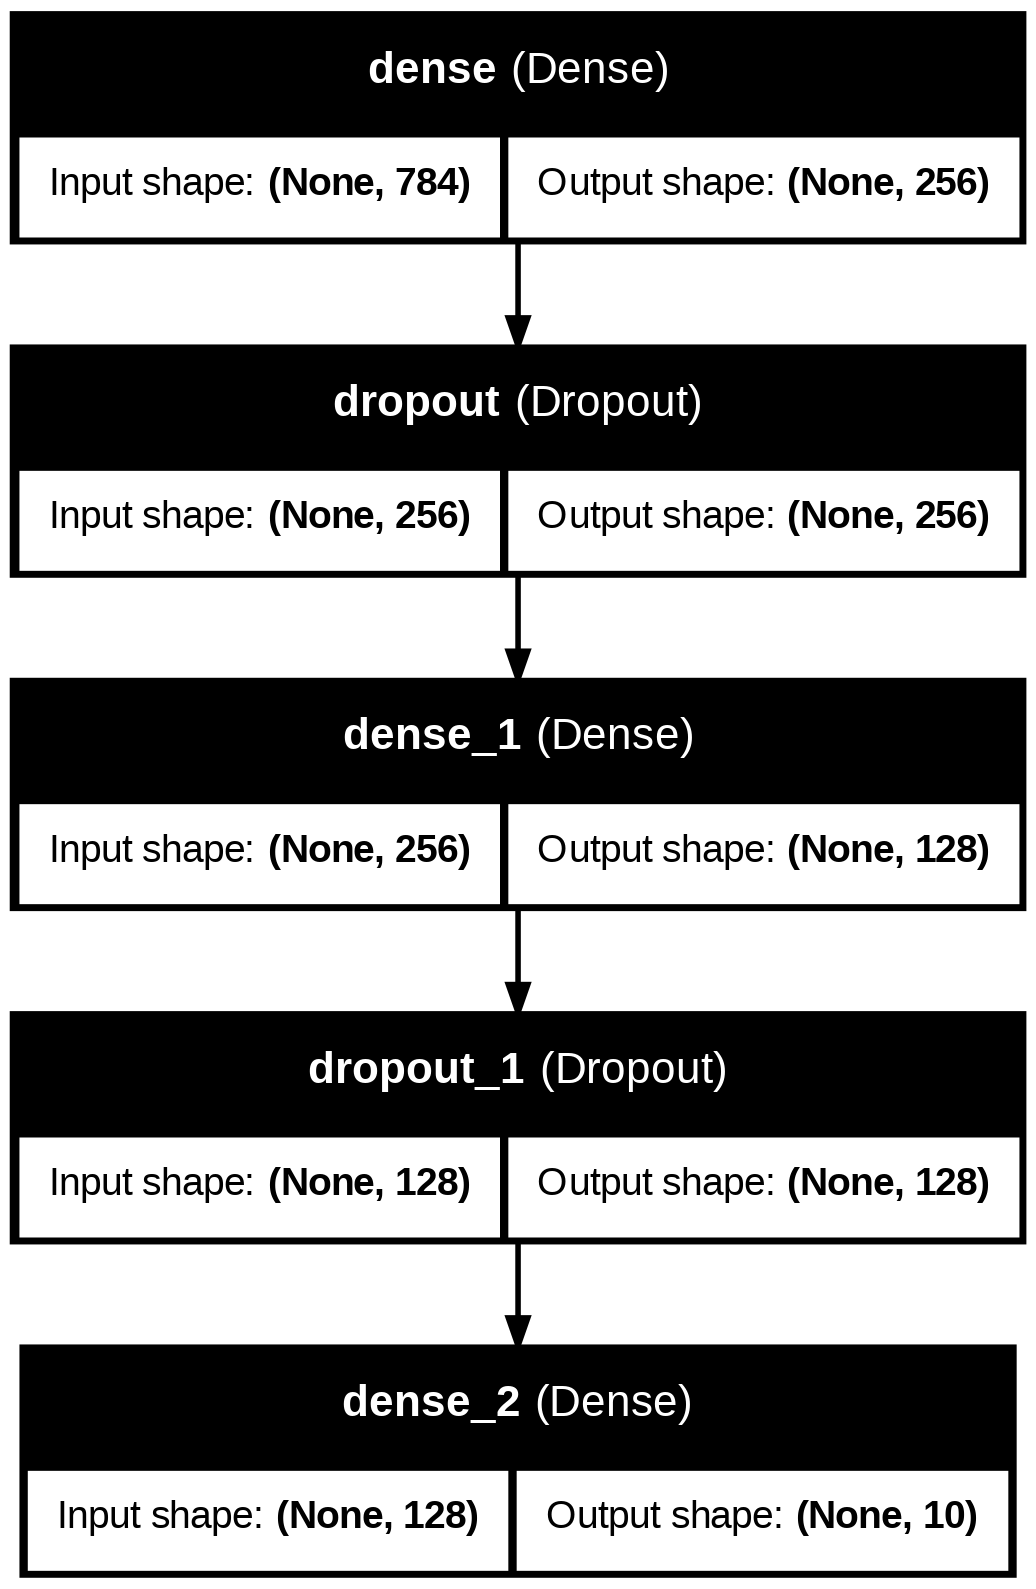

In [ ]:
plot_model(model, to_file="model.png",show_shapes=True, show_layer_names=True)

Prétraitement des données (mise à plat des images 28x28 en vecteurs 784)

In [ ]:
X_train_1D = train_images.reshape(-1, 28*28)
X_test_1D = test_images.reshape(-1, 28*28)

print(f'X_train_1D shape: {X_train_1D.shape}')
print(f'y_train_oh shape: {y_train_oh.shape}')
print(f'X_test_1D shape: {X_test_1D.shape}')
print(f'y_test_oh shape: {y_test_oh.shape}')

X_train_1D shape: (60000, 784)
y_train_oh shape: (60000, 10)
X_test_1D shape: (10000, 784)
y_test_oh shape: (10000, 10)


In [ ]:
history = model.fit(X_train_1D, y_train_oh, epochs=20, batch_size=50, validation_split=0.2)

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2804 - loss: 2.0078 - weighted_accuracy: 0.2804 - val_accuracy: 0.5874 - val_loss: 1.2799 - val_weighted_accuracy: 0.5874
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5407 - loss: 1.3726 - weighted_accuracy: 0.5407 - val_accuracy: 0.6788 - val_loss: 1.0126 - val_weighted_accuracy: 0.6788
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6096 - loss: 1.1788 - weighted_accuracy: 0.6096 - val_accuracy: 0.7231 - val_loss: 0.8691 - val_weighted_accuracy: 0.7231
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6449 - loss: 1.0800 - weighted_accuracy: 0.6449 - val_accuracy: 0.7303 - val_loss: 0.8477 - val_weighted_accuracy: 0.7303
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6731 - loss: 1.0017 - weighted_accuracy: 0.6731 - val_accuracy: 0.7677 - val_loss: 0.7540 - val_weighted_accuracy: 0.7677
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


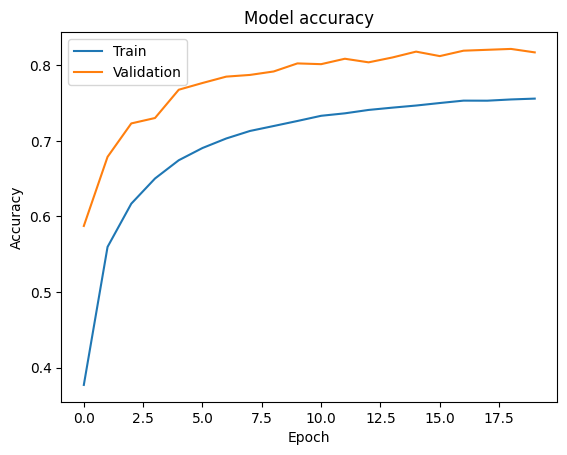

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

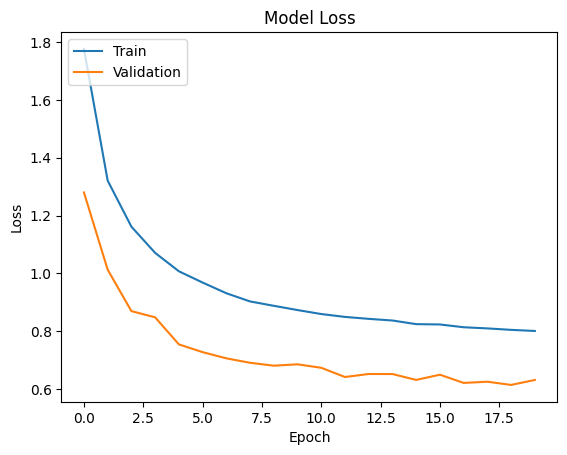

In [ ]:
# Visualisation de la perte (loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.evaluate(X_test_1D, y_test_oh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7446 - loss: 219.5660 - weighted_accuracy: 0.7446


[201.09983825683594,
 0.7577999830245972,
 0.7577999830245972,
 0.7577999830245972]

In [ ]:
y_pred = model.predict(X_test_1D)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

y_test_classes = np.argmax(y_test_oh,axis = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_test_classes

array([7, 2, 1, ..., 4, 5, 6])

<Axes: >

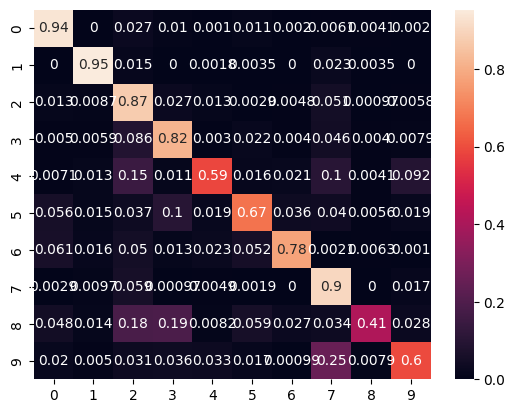

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes, normalize="true"), annot=True)

<Axes: >

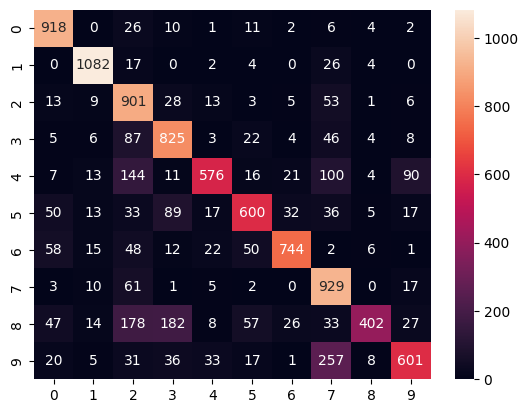

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d')

## **4. Deuxième apprentissage avec des couches de convolution 2D**

Transformation

In [ ]:
# Normalisation des valeurs de pixels
X_cnn_train = train_images.astype('float32') / 255.0
X_cnn_test = test_images.astype('float32') / 255.0
print(X_cnn_train.shape)
print(y_train_oh.shape)
print(X_cnn_test.shape)
print(y_test_oh.shape)


(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from keras import optimizers

def cnn_convolution_2D():
    model = Sequential()

    # Première couche de convolution 2D
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Deuxième couche de convolution 2D
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Couche Flatten
    model.add(Flatten())

    # Couche fully connected
    model.add(Dense(128, activation='relu'))

    # Couche de sortie pour 10 classes
    model.add(Dense(10, activation='softmax'))

    # Compilation du modèle avec categorical_crossentropy
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model



In [ ]:
model_cnn = cnn_convolution_2D()
print(f'{model_cnn.summary()}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

None


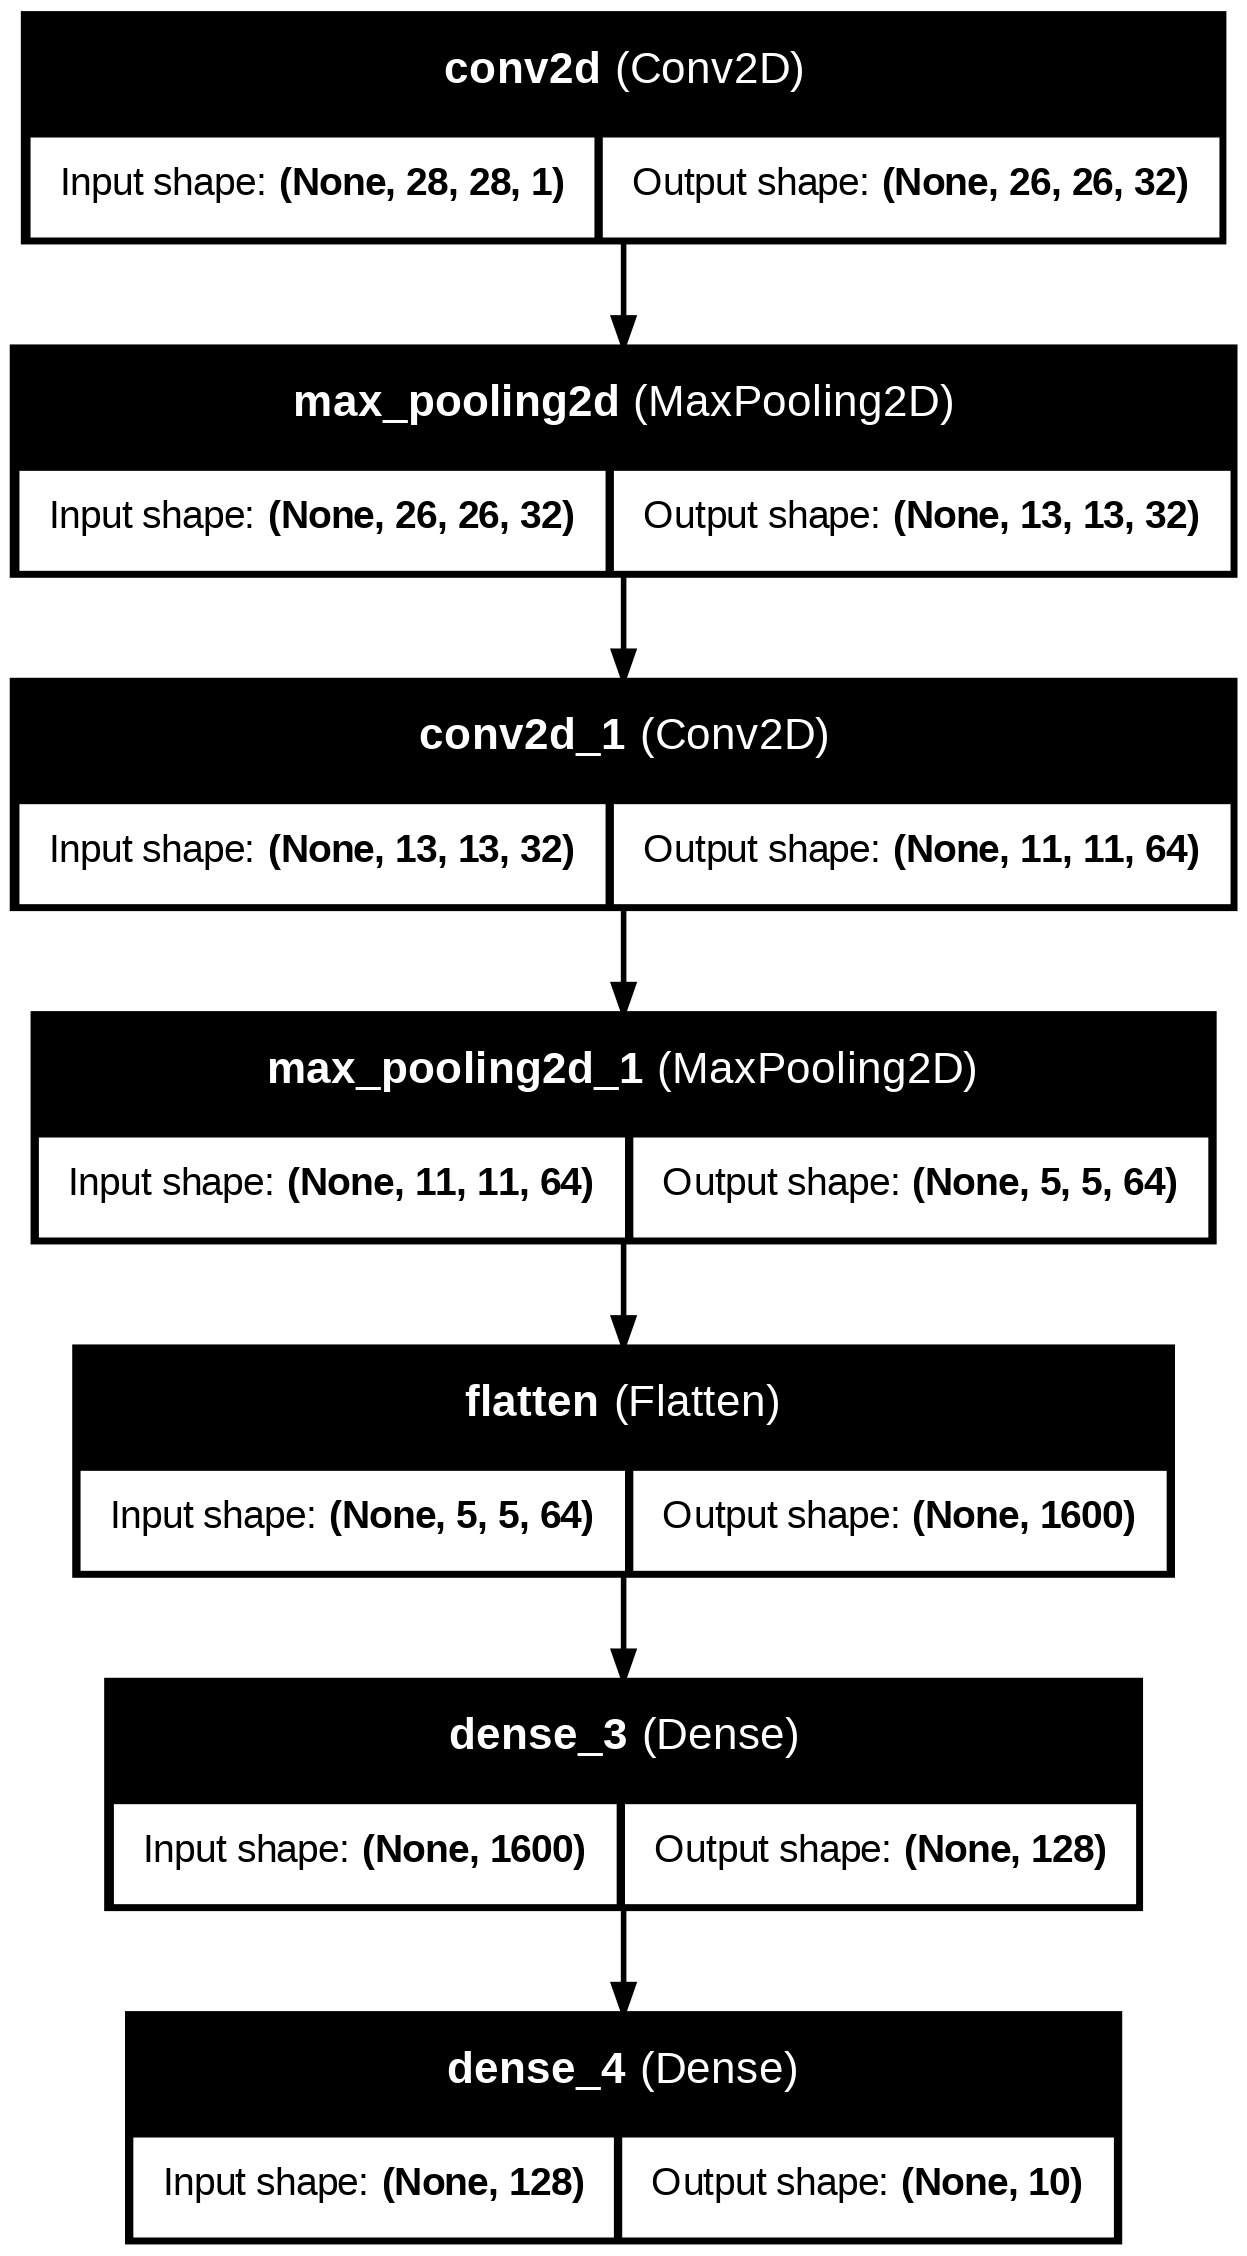

In [ ]:
plot_model(model_cnn, to_file="model_cnn.png",
               show_shapes=True, show_layer_names=True)

In [ ]:
print(X_cnn_train.shape)
print(y_train_oh.shape)

(60000, 28, 28, 1)
(60000, 10)


In [ ]:
history_cnn = model_cnn.fit(X_cnn_train, y_train_oh, validation_split=0.2, epochs=20, batch_size=50)

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 49s 50ms/step - accuracy: 0.1491 - loss: 2.2506 - weighted_accuracy: 0.1491 - val_accuracy: 0.2433 - val_loss: 2.0669 - val_weighted_accuracy: 0.2433
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.2717 - loss: 2.0147 - weighted_accuracy: 0.2717 - val_accuracy: 0.3794 - val_loss: 1.7723 - val_weighted_accuracy: 0.3794
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 86s 53ms/step - accuracy: 0.4090 - loss: 1.7055 - weighted_accuracy: 0.4090 - val_accuracy: 0.4653 - val_loss: 1.5418 - val_weighted_accuracy: 0.4653
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.4930 - loss: 1.4946 - weighted_accuracy: 0.4930 - val_accuracy: 0.5388 - val_loss: 1.3705 - val_weighted_accuracy: 0.5388
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 84s 52ms/step - accuracy: 0.5418 - loss: 1.3571 - weighted_accuracy: 0.5418 - val_accuracy: 0.5672 - val_loss: 1.2850 - val_weighted_accuracy: 0.5672
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/s

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


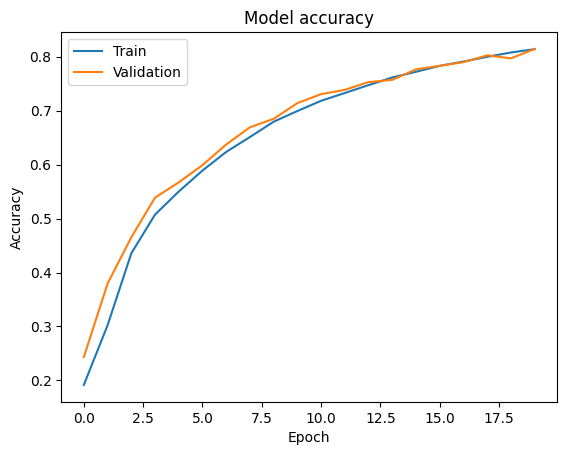

In [53]:
print(history_cnn.history.keys())
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

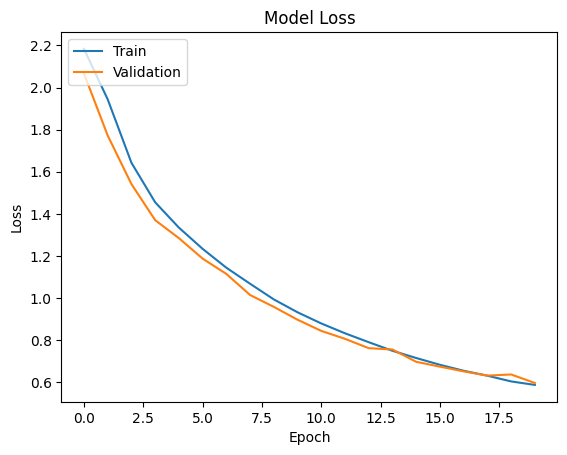

In [54]:
# Visualisation de la perte (loss)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_cnn.evaluate(X_cnn_test,y_test_oh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5880 - loss: 293.8892 - weighted_accuracy: 0.5880


[283.366455078125, 0.59170001745224, 0.59170001745224, 0.59170001745224]

In [ ]:
y_predcnn = model_cnn.predict(X_cnn_test)
y_predcnn_classes = np.argmax(y_predcnn,axis = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


<Axes: >

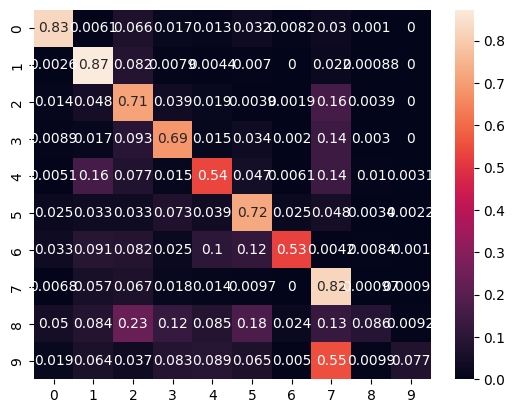

In [ ]:
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnn_classes, normalize="true"), annot=True)

<Axes: >

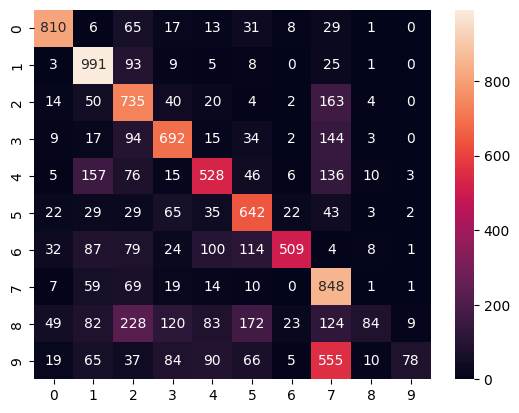

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnn_classes), annot=True, fmt='d')

Class weighting

In [ ]:
print(test_images.shape)
print(test_labels.shape)
print(y_train_oh[0])

(10000, 28, 28, 1)
(10000,)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [55]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(test_labels),
                                        y = test_labels
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 1.0204081632653061, 1: 0.8810572687224669, 2: 0.9689922480620154, 3: 0.9900990099009901, 4: 1.0183299389002036, 5: 1.1210762331838564, 6: 1.0438413361169103, 7: 0.9727626459143969, 8: 1.0266940451745379, 9: 0.9910802775024777}



Utilisation de l'arrêt anticipé avec EarlyStopping

In [56]:
from tensorflow.keras import callbacks

callback = callbacks.EarlyStopping(
    monitor='val_weighted_accuracy',  # Surveiller la métrique de précision pondérée
    patience=5,  # Arrêt anticipé après 5 epochs sans amélioration
    mode='max'   # Cherche à maximiser la métrique (précision pondérée)
)

Entraînement du modèle avec des poids de classe

In [57]:
model_cnn_w = cnn_convolution_2D()

history_cnn_w = model_cnn_w.fit(
    X_cnn_train,            # Les données d'entraînement
    y_train_oh,               # Les labels one-hot de l'entraînement
    validation_split=0.2,  # Utilise 20 % des données pour la validation
    epochs=20,             # Nombre d'epochs
    batch_size=50,         # Taille des lots
    class_weight=class_weights,  # Poids de classe pour ajuster l'importance des erreurs
    callbacks=[callback]   # Arrêt anticipé pour éviter le surapprentissage
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.2045 - loss: 2.1591 - weighted_accuracy: 0.2011 - val_accuracy: 0.5149 - val_loss: 1.4600 - val_weighted_accuracy: 0.5149
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.5736 - loss: 1.3222 - weighted_accuracy: 0.5688 - val_accuracy: 0.6921 - val_loss: 0.9768 - val_weighted_accuracy: 0.6921
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 84s 51ms/step - accuracy: 0.7066 - loss: 0.9374 - weighted_accuracy: 0.7031 - val_accuracy: 0.7545 - val_loss: 0.7853 - val_weighted_accuracy: 0.7545
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.7655 - loss: 0.7589 - weighted_accuracy: 0.7629 - val_accuracy: 0.7978 - val_loss: 0.6556 - val_weighted_accuracy: 0.7978
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.8051 - loss: 0.6328 - weighted_accuracy: 0.8031 - val_accuracy: 0.8259 - val_loss: 0.5609 - val_weighted_accuracy: 0.8259
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/s

In [ ]:
model_cnn_w.evaluate(X_cnn_test,y_test_oh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6575 - loss: 307.1874 - weighted_accuracy: 0.6575


[294.98138427734375, 0.660099983215332, 0.660099983215332, 0.660099983215332]

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


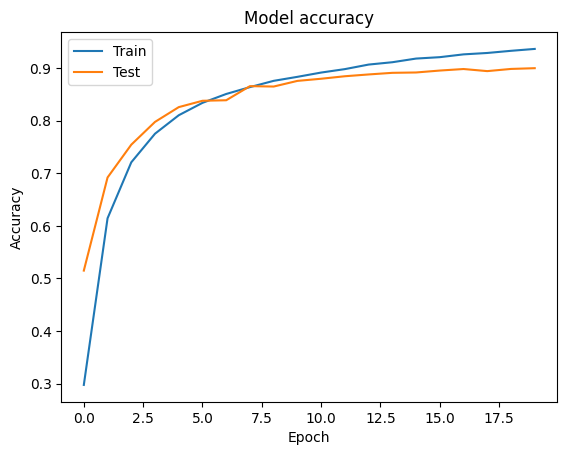

In [58]:
print(history_cnn_w.history.keys())
plt.plot(history_cnn_w.history['accuracy'])
plt.plot(history_cnn_w.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

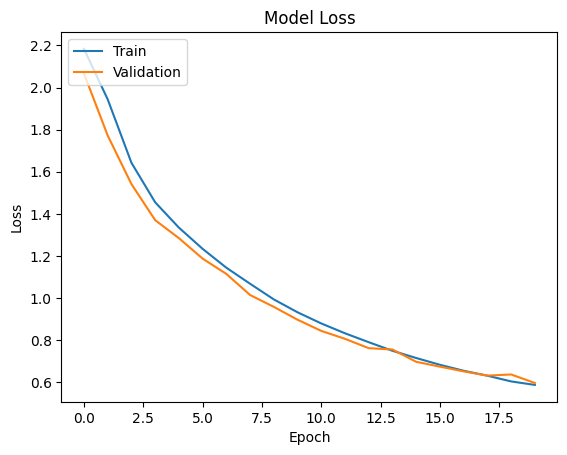

In [59]:
# Visualisation de la perte (loss)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


<Axes: >

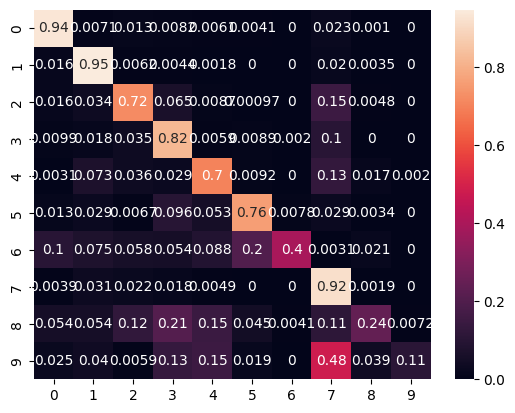

In [ ]:
y_predcnnw = model_cnn_w.predict(X_cnn_test)
y_predcnnw_classes = np.argmax(y_predcnnw,axis = 1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnnw_classes, normalize="true"), annot=True)

<Axes: >

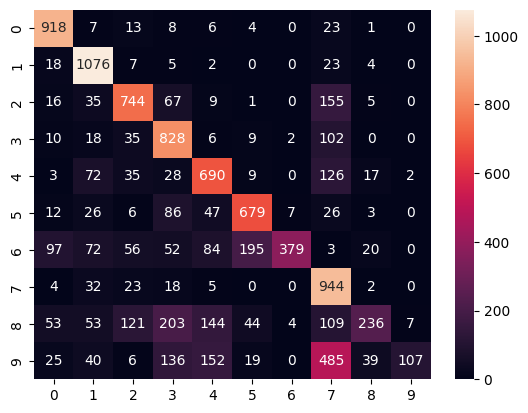

In [ ]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnnw_classes), annot=True, fmt='d')

## **5. Variation des paramètres**



*   **Taux d'apprentissage (Learning Rate)**



In [ ]:
# Expérimentation avec un learning rate plus bas
opt = optimizers.Adam(learning_rate=0.0001)
model_cnn_w.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

# Réentraînement du modèle
history_cnn_w = model_cnn_w.fit(X_cnn_train, y_train_oh, validation_split=0.2, epochs=20, batch_size=50, class_weight=class_weights, callbacks=[callback])


Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.9327 - loss: 0.2250 - weighted_accuracy: 0.9322 - val_accuracy: 0.8964 - val_loss: 0.3463 - val_weighted_accuracy: 0.8964
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.9357 - loss: 0.2095 - weighted_accuracy: 0.9351 - val_accuracy: 0.8960 - val_loss: 0.3489 - val_weighted_accuracy: 0.8960
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 48s 50ms/step - accuracy: 0.9377 - loss: 0.2059 - weighted_accuracy: 0.9373 - val_accuracy: 0.8964 - val_loss: 0.3464 - val_weighted_accuracy: 0.8964
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 84s 52ms/step - accuracy: 0.9404 - loss: 0.2014 - weighted_accuracy: 0.9399 - val_accuracy: 0.8944 - val_loss: 0.3480 - val_weighted_accuracy: 0.8944
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.9387 - loss: 0.2055 - weighted_accuracy: 0.9383 - val_accuracy: 0.8967 - val_loss: 0.3487 - val_weighted_accuracy: 0.8967
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 85s 53ms/s



*   **Nombre d'epochs:** Le nombre d'epochs a été augmenté, soit une valeur de 50





*   **Taille des lots (Batch Size)**



Batch_size = 64

In [60]:
history_cnn_w_64 = model_cnn_w.fit(X_cnn_train, y_train_oh, validation_split=0.2, epochs=50, batch_size=64, class_weight=class_weights, callbacks=[callback])

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.9443 - loss: 0.1758 - weighted_accuracy: 0.9440 - val_accuracy: 0.9061 - val_loss: 0.3301 - val_weighted_accuracy: 0.9061
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.9499 - loss: 0.1623 - weighted_accuracy: 0.9496 - val_accuracy: 0.9026 - val_loss: 0.3367 - val_weighted_accuracy: 0.9026
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.9506 - loss: 0.1568 - weighted_accuracy: 0.9503 - val_accuracy: 0.8947 - val_loss: 0.3556 - val_weighted_accuracy: 0.8947
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.9522 - loss: 0.1518 - weighted_accuracy: 0.9519 - val_accuracy: 0.9086 - val_loss: 0.3314 - val_weighted_accuracy: 0.9086
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.9520 - loss: 0.1469 - weighted_accuracy: 0.9518 - val_accuracy: 0.9053 - val_loss: 0.3434 - val_weighted_accuracy: 0.9053
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 63ms/s

In [61]:
model_cnn_w.evaluate(X_cnn_test,y_test_oh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6836 - loss: 368.3902 - weighted_accuracy: 0.6836


[369.64776611328125,
 0.6881999969482422,
 0.6881999969482422,
 0.6881999969482422]

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


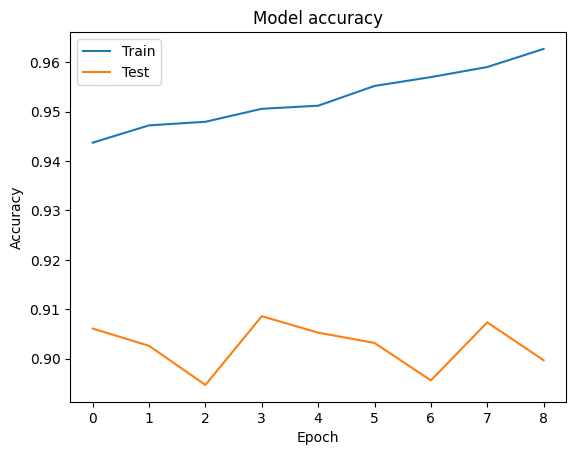

In [62]:
print(history_cnn_w_64.history.keys())
plt.plot(history_cnn_w_64.history['accuracy'])
plt.plot(history_cnn_w_64.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


<Axes: >

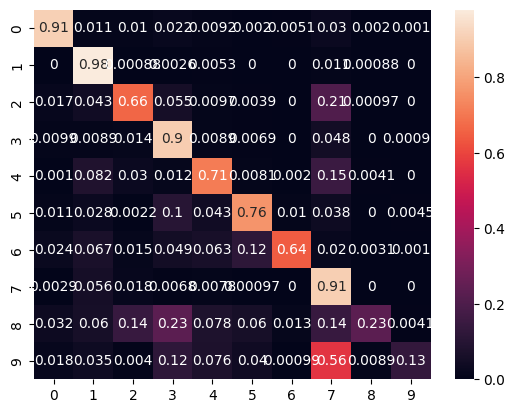

In [63]:
y_predcnnw = model_cnn_w.predict(X_cnn_test)
y_predcnnw_classes = np.argmax(y_predcnnw,axis = 1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnnw_classes, normalize="true"), annot=True)

<Axes: >

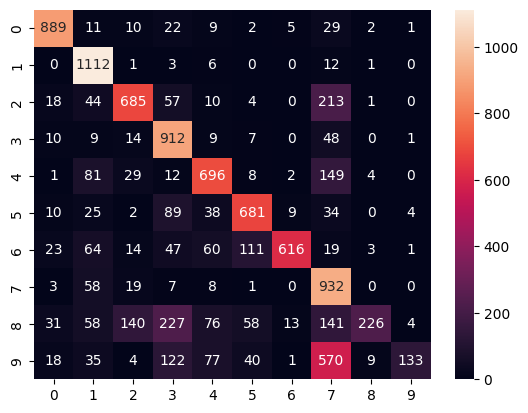

In [64]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnnw_classes), annot=True, fmt='d')

# **6. Comparaison des résulats des deux approches (Modèle Dense vs modèle CNN)**

Cf présentation